# LSTM for Validation
- 같은 Train Set에서 Train set과 Validation set을 나눈 후, 사전에 모델을 평가하기 위한 코드입니다.
- 최종 제출은 Test Set으로 진행하므로, 이에 대한 것은 LSTM for Submit 파일을 참고해주세요.

### 패키지 로딩

In [165]:
### Data Handling
import pandas as pd
import numpy as np

### fix seed
import random
import os
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42)

### Keras and TensorFlow
import keras
import tensorflow as tf

### Scoring
import sklearn.metrics as metrics

### 데이터 로딩

In [166]:
X = pd.read_csv("C:\LG_Aimers\data\Train-Test-Split\X_train.csv")
y = pd.read_csv("C:/LG_Aimers/data/Train-Test-Split/y_train.csv")

### 데이터 전처리

#### 같은 값을 가지는 열을 모두 제거

In [167]:
### X 데이터의 열 중 같은 값을 가지는 열을 모두 제거
X_desc = X.describe().T.reset_index()
X_is_1=list(X_desc[X_desc["mean"] == 1]['index'])
X.drop(columns = X_is_1, inplace = True)

print(X.shape)
print(y.shape)

### Validation set에도 동일한 절차로 진행
X_valid = pd.read_csv("C:\LG_Aimers\data\Train-Test-Split\X_valid.csv")
y_valid = pd.read_csv("C:/LG_Aimers/data/Train-Test-Split/y_valid.csv")
X_valid = X_valid.drop(columns = ["Unnamed: 0"])
X_valid.drop(columns = X_is_1, inplace = True)
X_valid=np.array(X_valid)
X_valid = X_valid.reshape(X_valid.shape[0],1,X_valid.shape[1])
y_valid = y_valid.drop(columns = ["Unnamed: 0"])
y_valid=np.array(y_valid)

#### 스펙 범위 내 데이터

In [171]:
### X 데이터 중 스펙범위 내 데이터만 가져옴
spec = pd.read_csv("C:\LG_Aimers\data\meta\y_feature_spec_info.csv")
for i in range(len(spec)) :
    X = X[y[spec["Feature"][i]].between(spec["최소"][i], spec["최대"][i])]
X.shape

### y 데이터 중 스펙범위 내 데이터만 가져옴
spec = pd.read_csv("C:\LG_Aimers\data\meta\y_feature_spec_info.csv")
for i in range(len(spec)) :
    y = y[y[spec["Feature"][i]].between(spec["최소"][i], spec["최대"][i])]
y.shape

#### 3차원 형 변환

In [174]:
X = X.drop(columns = ["Unnamed: 0"])
X=np.array(X)
X = X.reshape(X.shape[0],1,X.shape[1])

y = y.drop(columns = ["Unnamed: 0"])
y=np.array(y)
y = y.reshape(y.shape[0],1,y.shape[1])

print("X : ", X.shape)
print("y : ", y.shape)

### 모델 구축

In [ ]:
### 모델 생성 함수 정의
def lstm_autoencoder():
    feature_number = X.shape[2]
    lstm_ae = keras.models.Sequential()
 
    # 인코더
    lstm_ae.add(keras.layers.LSTM(64, activation="relu", input_shape=(1, feature_number), return_sequences=True))
    lstm_ae.add(keras.layers.LSTM(32, activation="relu", return_sequences=True))
    lstm_ae.add(keras.layers.LSTM(16, activation="relu", return_sequences=False))
    lstm_ae.add(keras.layers.RepeatVector(1))
    lstm_ae.add(keras.layers.LSTM(16, activation="relu", return_sequences=True))
    lstm_ae.add(keras.layers.LSTM(32, activation="relu", return_sequences=True))
    lstm_ae.add(keras.layers.LSTM(64, activation="relu", return_sequences=True))
    # 디코더
    lstm_ae.add(keras.layers.TimeDistributed(keras.layers.Dense(14)))
    return lstm_ae
 
lstm_ae0 = lstm_autoencoder()

### 모델 최적화

In [ ]:
# 파라미터 설정
epochs = 300
batch_size = 256
learning_rate = 0.01
validation = 0.2

# compile
lstm_ae0.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate))

# 모델학습
history = lstm_ae0.fit(
    X,
    y,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")
    ],
)
 
lstm_ae0.save('lstm_ae0.h5') # 모델 저장

### 모델 학습 과정 평가

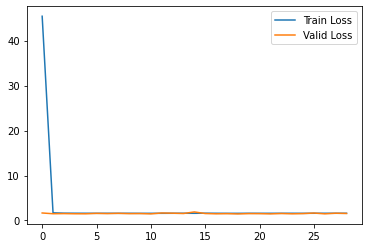

In [181]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Valid Loss")
plt.legend()
plt.show()

### 예측 및 평가

In [182]:
### 예측
y_predict = lstm_ae0.predict(X_valid)
y_predict = np.array(y_predict)
y_predict = y_predict.reshape(y_predict.shape[0],y_predict.shape[2])

### 스코어링 함수 정의
def lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(0,14): # ignore 'ID'
        rmse = metrics.mean_squared_error(gt[:,idx], preds[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:15])
    return score

In [187]:
### 평가
lg_nrmse(y_valid, y_predict)

2.1802411382939515